# lab3:Density Peak Clustering

## 1.Load data

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score

In [59]:
# 从dataset中读取数据
aggregation_path = 'datasets/Aggregation.txt'
D31_path = 'datasets/D31.txt'
R15_path = 'datasets/R15.txt'

aggregation_data = pd.read_csv(aggregation_path, sep=' ', header=None)
D31_data = pd.read_csv(D31_path, sep=' ', header=None)
R15_data = pd.read_csv(R15_path, sep=' ', header=None)

# 检查数据中是否有缺失值
print(aggregation_data.isnull().any())
print(D31_data.isnull().any())
print(R15_data.isnull().any())

0    False
1    False
dtype: bool
0    False
1    False
dtype: bool
0    False
1    False
dtype: bool


## 2.Data visualization
### 2.1 Aggregation

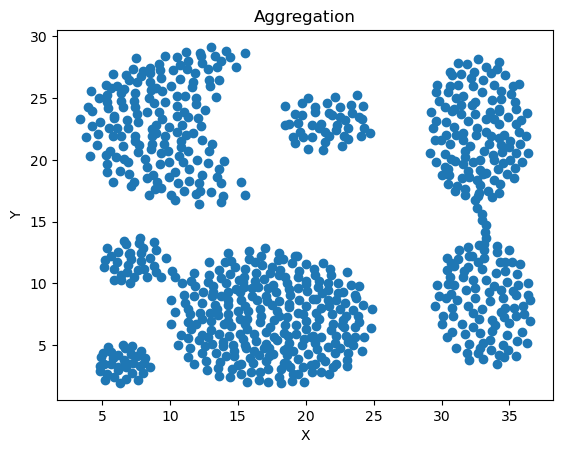

In [60]:
# 画出数据的分布图
X = aggregation_data.iloc[:, 0]
Y = aggregation_data.iloc[:, 1]
# 绘制散点图
plt.title('Aggregation')
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(X, Y)
plt.show()

## 2.2 D31

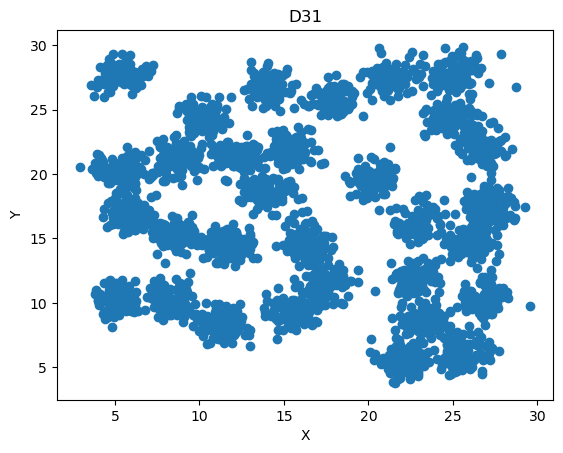

In [61]:
plt.title('D31')
plt.xlabel('X')
plt.ylabel('Y')
X = D31_data.iloc[:, 0]
Y = D31_data.iloc[:, 1]
plt.scatter(X, Y)
plt.show()

## 2.3 R15

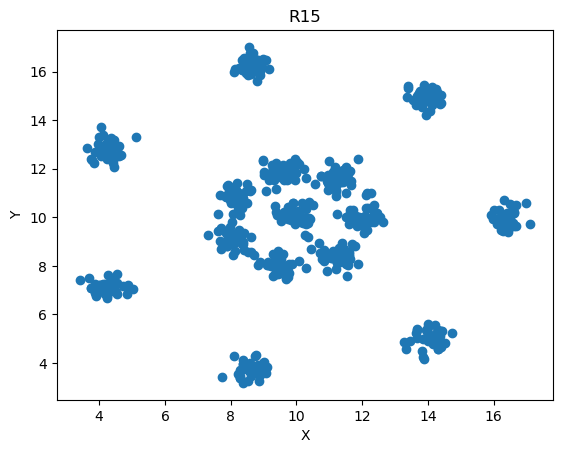

In [62]:
plt.title('R15')
plt.xlabel('X')
plt.ylabel('Y')
X = R15_data.iloc[:, 0]
Y = R15_data.iloc[:, 1]
plt.scatter(X, Y)
plt.show()

## 3. DPC algorithm

In [63]:
class DPC:
    def __init__(self, Data, percent=2.0, sigma=1.0):
        """
        init a DPC object

        parameters:
        - d_c: float, the threshold of distance
        - Data: numpy array, the data to be clustered
        - percent: float, the percent of distance
        - sigma: float, the sigma of gaussian kernel
        """
        self.d_c = None
        self.percent = percent
        self.sigma = sigma
        self.data = Data # 数据
        self.distances = None # 距离矩阵
        self.density = None # 局部密度
        self.delta = None # 最近距离
        self.gamma = None 
        self.cluster_center_indices = None # 聚类中心的索引
        self.cluster_assignment = None # 聚类结果
        self.calculate_distance()
        self.calculate_d_c()

    def calculate_distance(self):
        num_points = self.data.shape[0]
        self.distances = np.zeros((num_points, num_points))

        for i in range(num_points):
            for j in range(i + 1, num_points):
                self.distances[i, j] = np.linalg.norm(self.data[i] - self.data[j],ord=2)
                self.distances[j, i] = self.distances[i, j]

    def calculate_d_c(self):
        N = self.distances.shape[0]
        tt = np.reshape(self.distances, N*N)
        position = int(N * (N - 1) * self.percent / 100)
        self.d_c = np.sort(tt)[position  + N]

    def calculate_local_density(self):
        num_points = self.data.shape[0]
        self.density = np.zeros(num_points)

        for i in range(num_points):
            self.density[i] = np.sum(np.exp(-(self.distances[i] ** 2) / (2 * self.sigma * self.d_c ** 2)))

    def calculate_delta(self):
        num_points = self.data.shape[0]
        self.delta = np.zeros(num_points)

        for i in range(num_points):
            min_distance = np.inf
            for j in range(num_points):
                if self.density[j] > self.density[i]:
                    if self.distances[i, j] < min_distance:
                        min_distance = self.distances[i, j]
            if min_distance == np.inf:
                min_distance = np.max(self.distances[i])
            self.delta[i] = min_distance

    def cluster(self, n):
        """
        choose n cluster centers and assign each point to the nearest cluster center

        parameters:
        - n: int, the number of cluster centers

        return:
        - cluster_center_indices: list, the indices of cluster centers
        - cluster_assignment: numpy array, the assignment of each point
        """
        self.gamma = self.density * self.delta
        self.cluster_center_indices = np.argsort(-self.gamma)[:n]
        self.cluster_assignment = np.argmin(self.distances[:, self.cluster_center_indices], axis=1)
        return self.cluster_center_indices,self.cluster_assignment

    def plot_decision_graph(self):
        self.calculate_local_density()
        self.calculate_delta()
        plt.title('decision graph')
        plt.xlabel('delta')
        plt.ylabel('density')
        plt.scatter(self.density,self.delta)
        plt.show()

## 4. Result visualization and Evaluation

In [64]:
# 把dataframe转换成array
aggregation_data = aggregation_data.values
D31_data = D31_data.values
R15_data = R15_data.values
data_list = [aggregation_data, D31_data, R15_data]

### aggregation

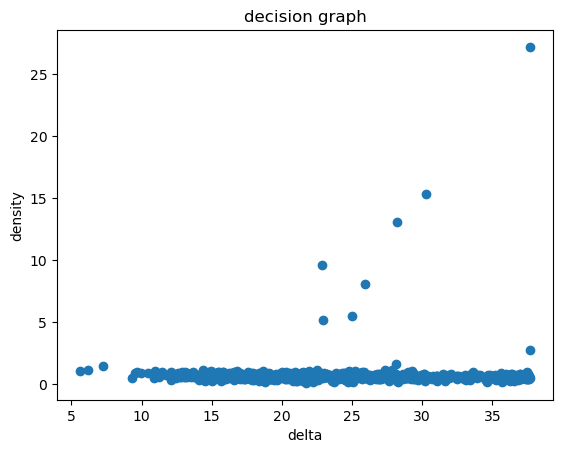

In [65]:
data = data_list[0]
model_1 = DPC(data, 1.637, 1)
model_1.plot_decision_graph()

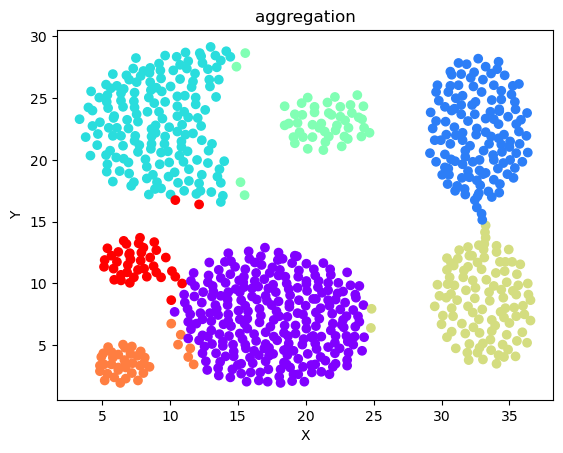

In [66]:
# 画出聚类结果
center,cluster = model_1.cluster(7)
# 设置簇标记到颜色的映射
colors = plt.cm.rainbow(np.linspace(0, 1, center.shape[0]))
color_mapping = {label: color for label, color in zip(range(center.shape[0]), colors)}
cluster_colors = [color_mapping[label] for label in cluster]
plt.title("aggregation")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(data[:,0],data[:,1],c=cluster_colors,marker='o')
plt.show()

In [67]:
# Evaluate the clustering
DBI = davies_bouldin_score(data, cluster)
print("DBI: ", DBI)

DBI:  0.5400317701696621


### D31

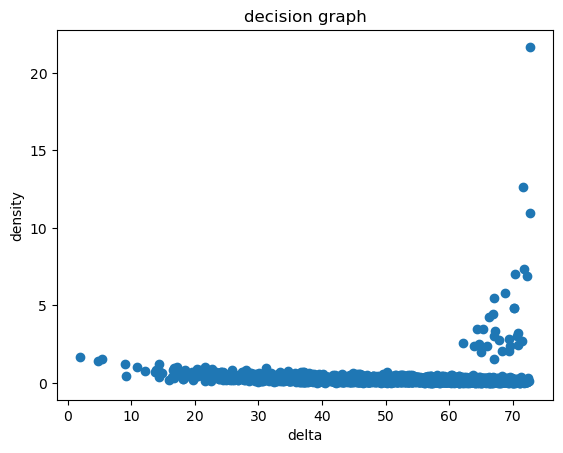

In [68]:
data = data_list[1]
model_2 = DPC(data,1.2)
model_2.plot_decision_graph()

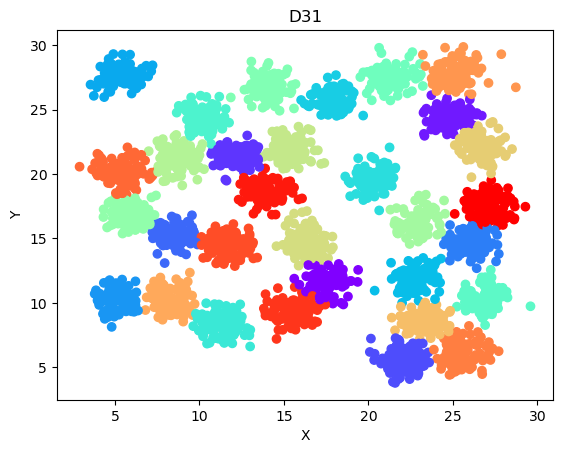

In [69]:
# 画出聚类结果
center,cluster = model_2.cluster(31)
# 设置簇标记到颜色的映射
colors = plt.cm.rainbow(np.linspace(0, 1, center.shape[0]))
color_mapping = {label: color for label, color in zip(range(center.shape[0]), colors)}
cluster_colors = [color_mapping[label] for label in cluster]
plt.title("D31")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(data[:,0],data[:,1],c=cluster_colors,marker='o')
plt.show()

In [70]:
# Evaluate the clustering
DBI = davies_bouldin_score(data, cluster)
print("DBI: ", DBI)

DBI:  0.5473027270482554


### R15

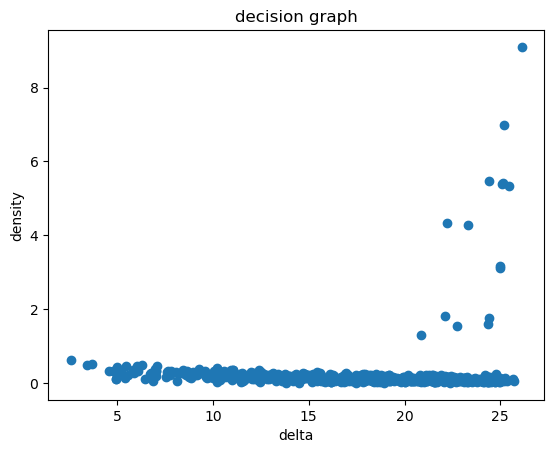

In [71]:
data = data_list[2]
model_3 = DPC(data,2)
model_3.plot_decision_graph()

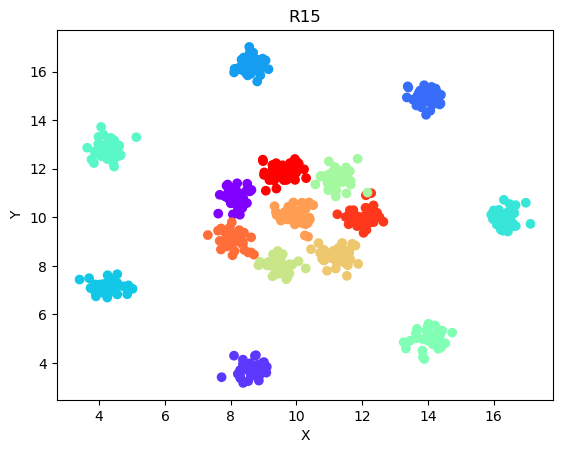

In [72]:
# 画出聚类结果
center,cluster = model_3.cluster(15)
# 设置簇标记到颜色的映射
colors = plt.cm.rainbow(np.linspace(0, 1, center.shape[0]))
color_mapping = {label: color for label, color in zip(range(center.shape[0]), colors)}
cluster_colors = [color_mapping[label] for label in cluster]
plt.title("R15")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(data[:,0],data[:,1],c=cluster_colors,marker='o')
plt.show()

In [73]:
# Evaluate the clustering
DBI = davies_bouldin_score(data, cluster)
print("DBI: ", DBI)

DBI:  0.3153116182896666


## Compare with Other Models in sklearn
我们以DPC算法表现最差的数据集Aggregation为例,使用sklearn库中的其它算法完成聚类,并与DPC算法比较

In [78]:
data = data_list[0]

### K-means

In [79]:
# KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(data)
labels = kmeans.labels_
# Evaluation
DBI = davies_bouldin_score(data, labels)
print("DBI: ", DBI)

d:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


DBI:  0.7331700637087574


### 层次聚类

In [80]:
# 层次聚类
from sklearn.cluster import AgglomerativeClustering
Agg_cluster = AgglomerativeClustering(n_clusters=7)
labels = Agg_cluster.fit_predict(data)
# Evaluation
DBI = davies_bouldin_score(data, labels)
print("DBI: ", DBI)

DBI:  0.7100972513852566


### DBSCAN

In [81]:
# DBSCAN
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)
labels = dbscan.fit_predict(data)
# Evaluation
DBI = davies_bouldin_score(data, labels)
print("DBI: ", DBI)

DBI:  0.638602045454667


### Mixtrue of Gaussian

In [82]:
# Mixtrue of Gaussian
from sklearn.mixture import GaussianMixture
GMM = GaussianMixture(n_components=7, random_state=42)
GMM.fit(data)
labels = GMM.predict(data)
# Evaluation
DBI = davies_bouldin_score(data, labels)
print("DBI: ", DBI)

DBI:  0.7165892624151932


d:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


可以看到,DPC算法显著优于这些算法